In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [196]:

class Stock:
    def __init__(self, name):
        self.name = name  # Store stock name
        self.file = f'day/{self.name}.csv'
        

        # Load CSV and ensure DatetimeIndex
        self.df = pd.read_csv(self.file, parse_dates=['Datetime'], index_col='Datetime')
        self.df.index = pd.to_datetime(self.df.index, utc=True)

        # Extract dayofweek from datetime index
        self.df['day_of_week'] = self.df.index.dayofweek
        
        # Compute hourly aggregated metrics
        grouped_price_change = self.df.groupby('day_of_week').apply(lambda x: (x['Close'] - x['Open']).mean()).to_frame(name='price_change')
        volume_mean = self.df.groupby('day_of_week')["Volume"].mean().to_frame(name='mean_volume')
        interhour_volatility = self.df.groupby('day_of_week').apply(lambda x: (x['High'] - x['Low']).mean()).to_frame(name='volatility')

        # Normalize volume and drop the original mean_volume column
        volume_mean['normalized_volume'] = (volume_mean['mean_volume'] - volume_mean['mean_volume'].min()) / (volume_mean['mean_volume'].max() - volume_mean['mean_volume'].min())
        volume_mean.drop(columns=['mean_volume'], inplace=True)

        # Merge all computed metrics into a single DataFrame
        self.grouped_df = grouped_price_change.merge(volume_mean, left_index=True, right_index=True).merge(
            interhour_volatility, left_index=True, right_index=True
        )

        # Rename columns to include stock name
        self.grouped_df.columns = [f"{self.name}_{col}" for col in self.grouped_df.columns]

        # Drop the 'day_of_week'' column as it's now in index and remove the original df['day_of_week'] column
        self.df.drop(columns=['day_of_week'], inplace=True)

        # Convert columns to float32 to save memory
        self.df = self.df.astype({'Open': 'float32', 'Close': 'float32', 'High': 'float32', 'Low': 'float32', 'Volume': 'float32'})
        self.grouped_df = self.grouped_df.astype('float32')

        # Delete intermediate variables to free memory
        del grouped_price_change, volume_mean, interhour_volatility

    def get_grouped_data(self):
        """Return the grouped and processed DataFrame."""
        return self.grouped_df


In [197]:
stocks = ['IWM', 'NVDA', 'QQQ', 'SPY', 'TSLA']
stock_objects = [Stock(stock) for stock in stocks]



C:\Users\shmue\AppData\Local\Temp\ipykernel_15064\2304653733.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_price_change = self.df.groupby('day_of_week').apply(lambda x: (x['Close'] - x['Open']).mean()).to_frame(name='price_change')
C:\Users\shmue\AppData\Local\Temp\ipykernel_15064\2304653733.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interhour_volatility = self.df.groupby('day_of_we


Day Name	.dt.dayofweek Value
Monday	0
Tuesday	1
Wednesday	2
Thursday	3
Friday	4
Saturday	5
Sunday	6

In [198]:
for stock in stock_objects:
    print(stock.grouped_df)

             IWM_price_change  IWM_normalized_volume  IWM_volatility
day_of_week                                                         
0                   -0.019200               0.000000        1.545638
1                   -0.026018               0.576870        1.603812
2                   -0.042194               0.868263        1.653805
3                   -0.030252               1.000000        1.670161
4                   -0.000883               0.787114        1.567067
             NVDA_price_change  NVDA_normalized_volume  NVDA_volatility
day_of_week                                                            
0                     0.034328                0.000000         0.306365
1                     0.011635                0.411784         0.307319
2                    -0.001921                0.630926         0.309770
3                    -0.024804                0.876781         0.328108
4                    -0.021283                1.000000         0.301707
             

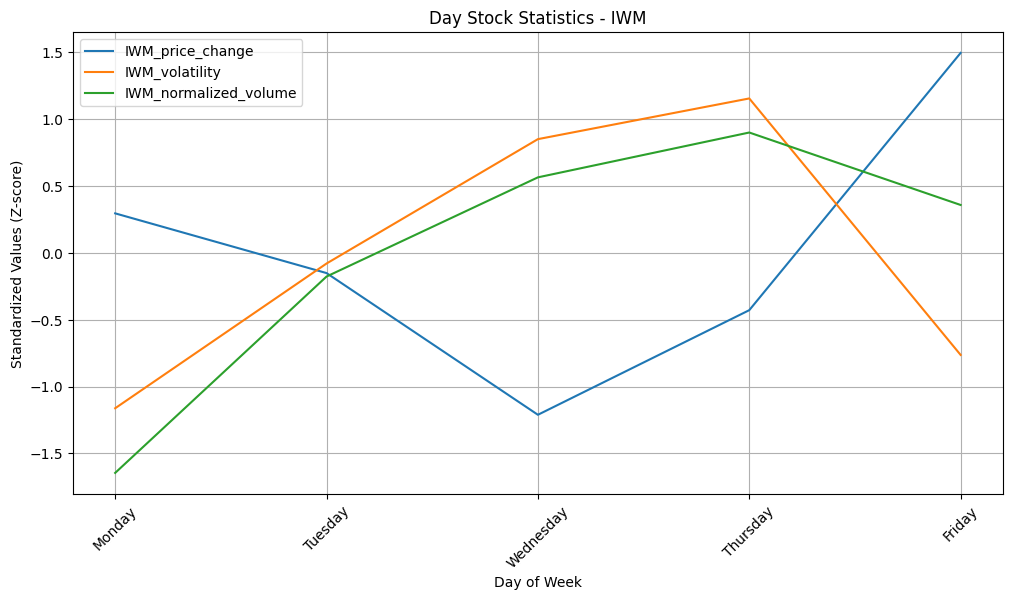

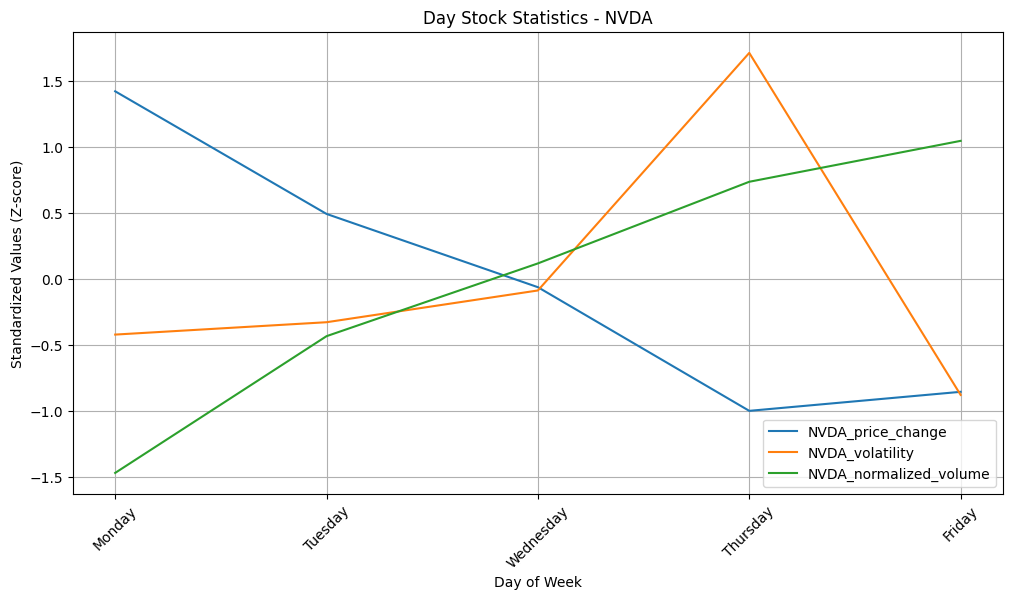

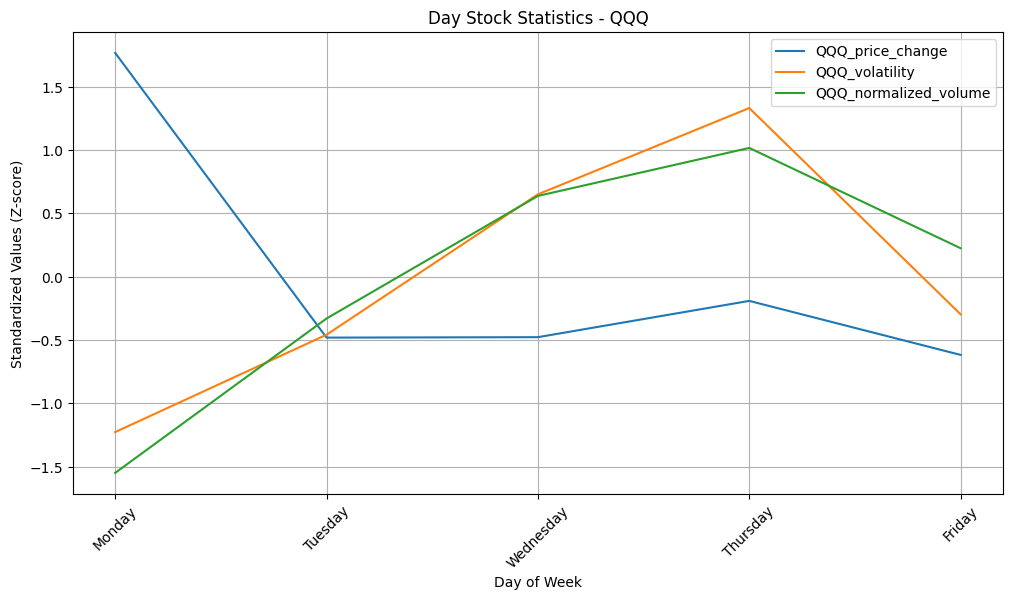

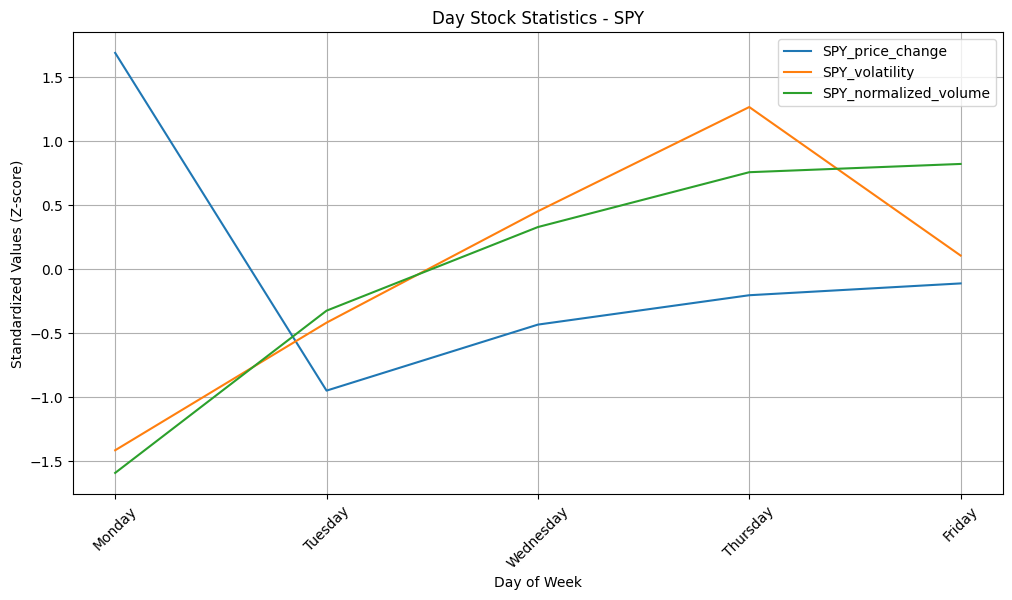

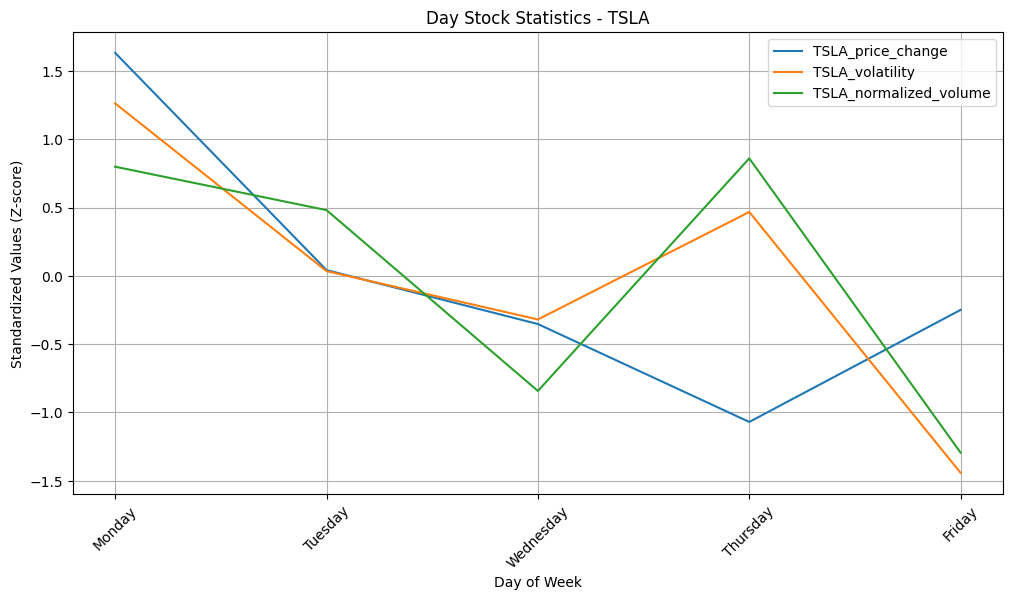

In [200]:


days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for stock in stock_objects:
    # Select only the numerical columns for normalization
    metrics = [f"{stock.name}_price_change", f"{stock.name}_volatility", f"{stock.name}_normalized_volume"]
    available_metrics = [col for col in metrics if col in stock.grouped_df.columns]

    # Apply Z-score normalization (standardization)
    for col in available_metrics:
        mean_val = stock.grouped_df[col].mean()
        std_val = stock.grouped_df[col].std()
        if std_val != 0:  # Avoid division by zero
            stock.grouped_df[col] = (stock.grouped_df[col] - mean_val) / std_val

    # Create a plot
    plt.figure(figsize=(12, 6))

    # Plot all metrics after normalization
    for column in available_metrics:
        plt.plot(stock.grouped_df.index, stock.grouped_df[column], label=column)

    # Ensure x-axis labels match (Convert index to weekday names dynamically)
    if len(stock.grouped_df.index) == len(days):  
        plt.xticks(ticks=stock.grouped_df.index, labels=days, rotation=45)
    else:
        print(f"Warning: Mismatch between index count ({len(stock.grouped_df.index)}) and day labels.")

    # Labels and Title
    plt.xlabel("Day of Week")
    plt.ylabel("Standardized Values (Z-score)")
    plt.title(f"Day Stock Statistics - {stock.name}")
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()
